## Analyze A/B Test Results

The goal is to help the company run by an e-commerce website to understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision by an A/B test .


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

Each row represents a unique user and shows whether they’re in the control or treatment group and whether they converted or not.

In [4]:
df.shape

(294478, 5)

In [5]:
# The number of unique users in the dataset
df.user_id.nunique()

290584

In [6]:
# The proportion of users converted
df.query('converted == 1')['converted'].count() / df.shape[0]

0.11965919355605512

In [7]:
# missing values
df.isnull().sum().sum()

0

In [8]:
df.query('group == "treatment" and landing_page != "new_page"').count()

user_id         1965
timestamp       1965
group           1965
landing_page    1965
converted       1965
dtype: int64

In [19]:
df.query('group == "control" and landing_page == "new_page"').count()[0]

1928

The control group and The treatment group, were exposed to an old webpage and a new webpage respectively. 

In [20]:
# Checking to see if there are any users in control that saw new page and users in treatment that saw old page
df.groupby(['group','landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

It seems that some of the control group saw the new page and some of the treatment group saw the old page.
Since we're not sure which way to switch it to, we're going to remove it

In [21]:
# Removing control/new_page and treatment/old_page
df_clean = df.loc[(df['group'] == 'control') & (df['landing_page'] == 'old_page') | (df['group'] == 'treatment') & (df['landing_page'] == 'new_page') ]

In [22]:
df_clean.groupby(['group','landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   old_page       145274     145274     145274
treatment new_page       145311     145311     145311

In [28]:
# Checking for duplicate values
df_clean['user_id'].duplicated().sum()

1

In [30]:
df_clean.user_id.value_counts().idxmax()

773192

In [35]:
df[df['user_id'] == 773192]

user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0

In [36]:
df_clean = df_clean.drop_duplicates(subset ='user_id', keep = "first") 

In [37]:
df_clean['user_id'].duplicated().sum()

0

In [41]:
df_clean.groupby(['group','landing_page','converted']).count()

user_id  timestamp
group     landing_page converted                    
control   old_page     0           127785     127785
                       1            17489      17489
treatment new_page     0           128046     128046
                       1            17264      17264

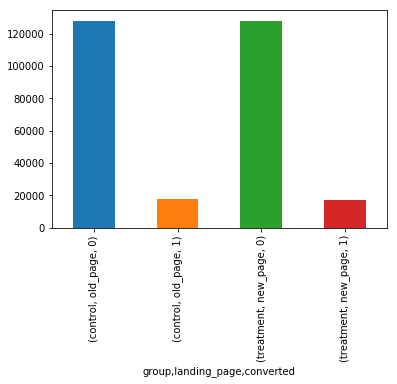

In [42]:
df_clean.groupby(['group','landing_page','converted']).size().plot(kind='bar')

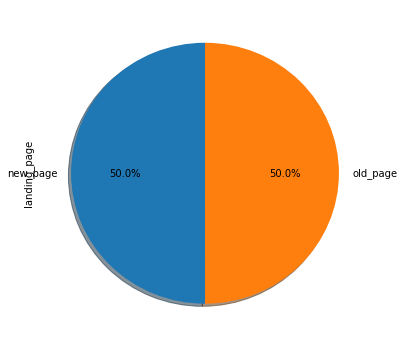

In [49]:
# Probability that an individual received the new_page and old_page
df_clean['landing_page'].value_counts().plot(kind='pie', shadow = True, startangle=90,figsize=(6,6), autopct='%1.1f%%')

In [50]:
# Probability of an individual converting regardless of the page they receive
df_clean.converted.mean()

0.11959708724499628

In [56]:
# Probability that an individual in the control group converted
control_cnvrt = df_clean.query('group == "control"').converted.mean()
control_cnvrt

0.1203863045004612

In [57]:
# Probability that an individual in the treatment group converted
treatment_cnvrt = df_clean.query('group == "treatment"').converted.mean()
treatment_cnvrt

0.11880806551510564

In [58]:
# 1) Split groups into two separate DataFrames
c = df_clean[df_clean['group'] == 'control']
t = df_clean[df_clean['group'] == 'treatment']

In [72]:
c.converted.value_counts()

0    127785
1     17489
Name: converted, dtype: int64

In [74]:
# Control-Click
c_click = c.converted.sum()

In [75]:
# Control-NoClick
c_noclick = c.converted.size - c.converted.sum()

In [76]:
# Treatment-Click
t_click = t.converted.sum()

In [77]:
# Treatment-NoClick
t_noclick = t.converted.size - t.converted.sum()

In [78]:
convert_table = np.array([[c_click, c_noclick], [t_click, t_noclick]])

In [82]:
#Observed Values
Observed_Values = convert_table 
print("Observed Values :-\n",Observed_Values)

Observed Values :-
 [[ 17489 127785]
 [ 17264 128046]]


In [80]:
val=stats.chi2_contingency(convert_table)
val

(1.7035660051885055,
 0.1918222809623566,
 1,
 array([[ 17374.34725243, 127899.65274757],
        [ 17378.65274757, 127931.34725243]]))

In [81]:
Expected_Values=val[3]

In [94]:
from scipy.stats import chi2
chi_square=sum([(o-e)**2./e for o,e in zip(Observed_Values,Expected_Values)])
chi_square_statistic=chi_square[0]+chi_square[1]
print("chi-square statistic:-",chi_square_statistic)

chi-square statistic:- 1.7185222540121272


In [92]:
#p-value 
p_value=1-chi2.cdf(x=chi_square_statistic,df=ddof)
print('p-value:',p_value)

p-value: 0.18988337448195192


In [93]:
print('p-value:',scipy.stats.chi2_contingency(convert_table,correction=False)[1])

p-value: 0.18988337448194853


The calculated p-value is 19%. Assuming a 5% level of significance, we can deduce that the p-value is greater than the alpha. In this case, we do not reject the null hypothesis. In simpler terms, there is no significance in conversions between the old and new webpage.

In [97]:
significance = 0.05
sample_success_a, sample_size_a = (c.converted.sum(), c.converted.size)
sample_success_b, sample_size_b = (t.converted.sum(), t.converted.size)
# check our sample against Ho for Ha != Ho
successes = np.array([sample_success_a, sample_success_b])
samples = np.array([sample_size_a, sample_size_b])
# note, no need for a Ho value here - it's derived from the other parameters
from statsmodels.stats.proportion import proportions_ztest
stat, p_value = proportions_ztest(count=successes, nobs=samples,  alternative='two-sided')
# report
print('z_stat: %0.3f, p_value: %0.3f' % (stat, p_value))
if p_value > significance:
   print ("Fail to reject the null hypothesis - we have nothing else to say")
else:
   print ("Reject the null hypothesis - suggest the alternative hypothesis is true")

z_stat: 1.311, p_value: 0.190
Fail to reject the null hypothesis - we have nothing else to say


In [99]:
# Calculating the conversion rates between the two groups
control_CTR = c_click / (c_click + c_noclick)
treatment_CTR = t_click / (t_click + t_noclick)
print(control_CTR, treatment_CTR)

0.1203863045004612 0.11880806551510564


The difference between them is minimal, which reassures that this was conducted properly.